In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import ipy_utils
import numpy as np
import pandas as pd

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Plot ROC Curves

In [4]:
GO_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')

In [5]:
lt_GO_terms_sc, lt_roc_aucs_sc = ipy_utils.get_prediction_results('results_log_transformed_scaled_score_0')
aucs_prob = ipy_utils.make_roc_curves(lt_GO_terms_sc, GO_counts)
print np.mean(aucs_prob)

KeyError: 'GO:0035774'

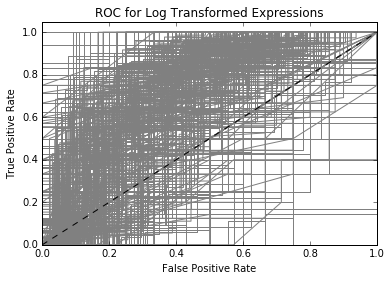

10 251


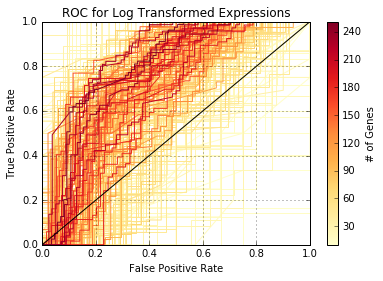

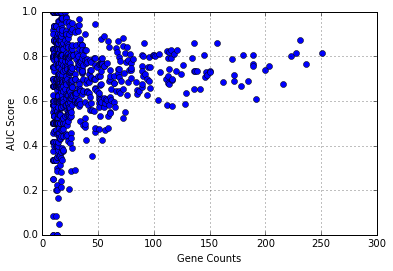

0.677452637059


In [92]:
lt_GO_terms_sc, lt_roc_aucs_sc = ipy_utils.get_prediction_results('results_log_transformed_scaled_score_0')
aucs_prob = ipy_utils.make_roc_curves(lt_GO_terms_sc, GO_counts)
print np.mean(aucs_prob)

In [106]:
print len(GO_counts.keys())

720


## Results Using 5-Fold CV, where the Train-Test Splitting Used Stratification. Using all 8555 Features (Not dimension-reduced), L1 Norm

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


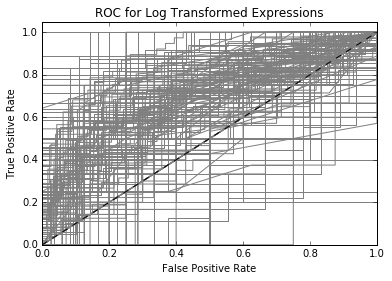

10 236


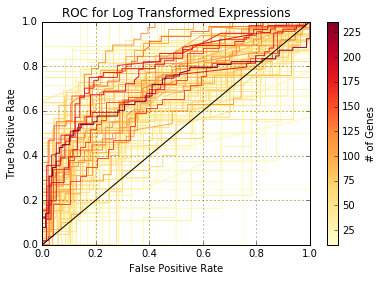

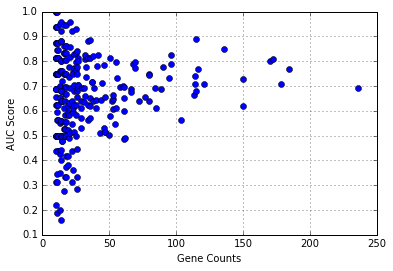

0.664746443568 0.664746443568


In [7]:
GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('results_all_tissues')
GO_gene_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
aucs_prob = ipy_utils.make_roc_curves(GO_terms, GO_gene_counts)
print np.mean(aucs_prob), np.mean(roc_aucs_strat)

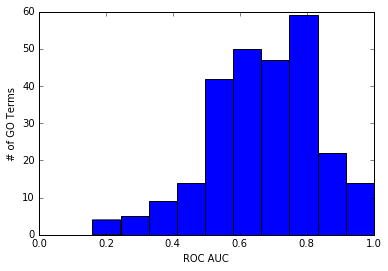

In [49]:
plt.hist(aucs_prob)
plt.xlim([0.0, 1.0])
plt.xlabel('ROC AUC')
plt.ylabel('# of GO Terms')
plt.show()